In [56]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from tqdm import tqdm


In [57]:
with open('/home/f20222001/test-venv/UHI/Datasets_processed/inputs_12_extra_clean.pkl', 'rb') as f, open('/home/f20222001/test-venv/UHI/Datasets_processed/targets_12_extra_clean.pkl','rb') as t:
    inputs = pickle.load(f)
    targets = pickle.load(t)
# Shuffle before splitting (preserves alignment of X and y)
X_shuffled, y_shuffled = shuffle(inputs, targets, random_state=42)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.9, random_state=42
)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=42
)

In [58]:
# with open("inputs_small_train_36.pkl", "wb") as f:
#     pickle.dump(X_train, f)

# with open("inputs_small_test_36.pkl", "wb") as f:
#     pickle.dump(X_test, f)
# # Save targets
# with open("targets_small_train_36.pkl", "wb") as f:
#     pickle.dump(y_train, f)
# with open("targets_small_test_36.pkl", "wb") as f:
#     pickle.dump(y_test, f)

In [59]:
# with open("inputs_small_train_36.pkl", "rb") as f:
#     X_train = pickle.load(f)

# with open("inputs_small_test_36.pkl", "rb") as f:
#     X_test = pickle.load(f)
# # Save targets
# with open("targets_small_train_36.pkl", "rb") as f:
#     Y_train = pickle.load(f)
# with open("targets_small_test_36.pkl", "rb") as f:
#     Y_test = pickle.load(f)

In [60]:
# Indexes of features to normalize
norm_idx = [0, 1, 2, 3] 

# Flatten for scaling
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_val_flat   = X_val.reshape(-1, X_val.shape[2])
X_test_flat  = X_test.reshape(-1, X_test.shape[2])

# Initialize arrays to hold the scaled data
X_train_scaled = X_train_flat.copy()
X_val_scaled   = X_val_flat.copy()
X_test_scaled  = X_test_flat.copy()

scaler = StandardScaler()

# Fit on train, transform all
X_train_scaled[:, norm_idx] = scaler.fit_transform(X_train_flat[:, norm_idx])
X_val_scaled[:, norm_idx]   = scaler.transform(X_val_flat[:, norm_idx])
X_test_scaled[:, norm_idx]  = scaler.transform(X_test_flat[:, norm_idx])

# Reshape back to 3D
X_train = X_train_scaled.reshape(X_train.shape)
X_val   = X_val_scaled.reshape(X_val.shape)
X_test  = X_test_scaled.reshape(X_test.shape)

# Flatten y
y_train_flat = Y_train.reshape(-1, 1)
y_val_flat   = Y_val.reshape(-1, 1)
y_test_flat  = Y_test.reshape(-1, 1)

# Standardize y
standard_scaler_y = StandardScaler()
y_train_scaled = standard_scaler_y.fit_transform(y_train_flat)
y_val_scaled   = standard_scaler_y.transform(y_val_flat)
y_test_scaled  = standard_scaler_y.transform(y_test_flat)

# Reshape back to original shape
Y_train = y_train_scaled.reshape(Y_train.shape)
Y_val   = y_val_scaled.reshape(Y_val.shape)
Y_test  = y_test_scaled.reshape(Y_test.shape)


In [61]:
X_train.shape

(23439, 12, 17)

In [62]:
X_train

array([[[ 9.67833042e-01,  1.68570101e-01,  2.03940898e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.51332903e-01,  1.08021486e+00, -5.69750845e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.24320877e+00,  1.91037985e-03, -4.21583839e-02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-2.12611914e+00, -1.36383545e+00, -3.27545077e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.02391553e+00,  5.93030572e-01, -2.05800459e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-8.90152037e-01,  2.01447845e+00, -1.91255331e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 6.99588537e-01,  4.55911905e-01, -9.76123586e-02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.37227951e-02,  5.56498051e-01, -7.69064724e-02, ...,
          0.00000000e+00,  0.00000000e

In [63]:
Y_train.shape

(23439,)

In [64]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(Y_train, dtype=torch.float32))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(Y_val, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(Y_test, dtype=torch.float32))

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [65]:
device = torch.device("cuda")
device

device(type='cuda')

In [66]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=1536, num_layers=3, dropout=0.3):
        super(LSTMPredictor, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)  # Output = scalar

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
        last_time_step = lstm_out[:, -1, :]  # take the last time step's output
        out = self.fc(last_time_step)  # (batch_size, 1)
        return out.squeeze(1)  # final shape: (batch_size,)
    


 10%|█         | 1/10 [00:01<00:09,  1.08s/it]

Epoch 1/10 - Train Loss: 1.0313177108764648
Epoch 2/10 - Train Loss: 1.0166046619415283


 30%|███       | 3/10 [00:03<00:07,  1.13s/it]

Epoch 3/10 - Train Loss: 0.6152501106262207


 40%|████      | 4/10 [00:04<00:06,  1.11s/it]

Epoch 4/10 - Train Loss: 0.6037013530731201


 50%|█████     | 5/10 [00:05<00:05,  1.10s/it]

Epoch 5/10 - Train Loss: 0.516593337059021


 60%|██████    | 6/10 [00:06<00:04,  1.13s/it]

Epoch 6/10 - Train Loss: 0.5226526260375977


 70%|███████   | 7/10 [00:07<00:03,  1.12s/it]

Epoch 7/10 - Train Loss: 0.39827731251716614


 80%|████████  | 8/10 [00:08<00:02,  1.11s/it]

Epoch 8/10 - Train Loss: 0.4486541748046875


 90%|█████████ | 9/10 [00:09<00:01,  1.10s/it]

Epoch 9/10 - Train Loss: 0.4068988263607025


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

Epoch 10/10 - Train Loss: 0.33212584257125854


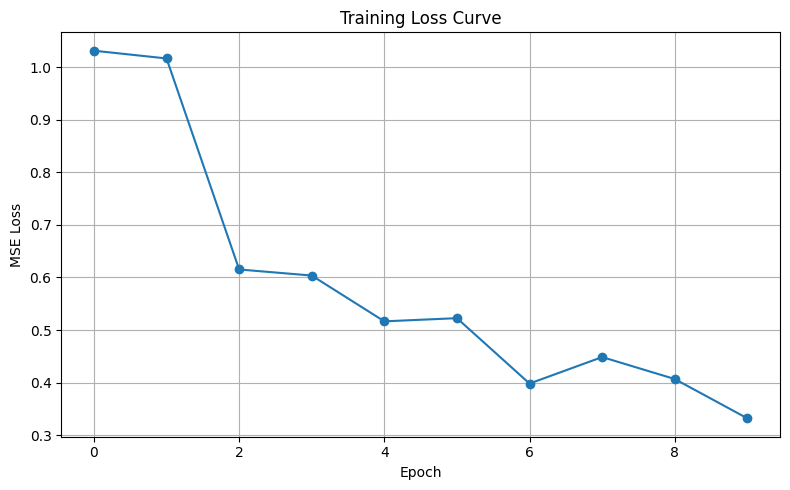

In [67]:
input_size = X_train.shape[2]  # num_features per timestep
model = LSTMPredictor(input_size=input_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Training loop
num_epochs = 10
train_losses = []
val_losses = {
    "mse": [],
    "rmse": [],
    "mae": [],
    "r2": []
}

for epoch in tqdm(range(num_epochs)):
    model.train()

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print(batch_x.shape)
        #print(batch_y.shape)
        # Forward
        preds = model(batch_x)  # shape: (batch_size,)
        #print(preds.shape)
        loss = criterion(preds, batch_y)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item()}")
    train_losses.append(loss.item())

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device)
            val_y = val_y.to(device)

            preds = model(val_x)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(val_y.cpu().numpy())

    # Concatenate and inverse scale
    all_preds_np = np.concatenate(all_preds).reshape(-1, 1)
    all_targets_np = np.concatenate(all_targets).reshape(-1, 1)

    y_pred = standard_scaler_y.inverse_transform(all_preds_np)
    y_true = standard_scaler_y.inverse_transform(all_targets_np)

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    val_losses["mse"].append(mse)
    val_losses["rmse"].append(rmse)
    val_losses["mae"].append(mae)
    val_losses["r2"].append(r2)


plt.figure(figsize=(8, 5))
plt.plot(np.arange(num_epochs),train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)
        
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true).reshape(-1, 1)
y_pred = np.array(y_pred).reshape(-1, 1)

# Unnormalize using RobustScaler
y_true = standard_scaler_y.inverse_transform(y_true)
y_pred = standard_scaler_y.inverse_transform(y_pred)

# Flatten back
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape=mean_absolute_percentage_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")
print(f"Test MAPE:   {mape:.4f}")

Test MSE:  30.7892
Test RMSE: 5.5488
Test MAE:  3.7331
Test R²:   0.6133
Test MAPE:   0.1938


In [69]:
val_losses['mae']

[6.945452690124512,
 6.761030673980713,
 5.396440029144287,
 4.701810359954834,
 4.326046466827393,
 4.102575778961182,
 4.242035865783691,
 3.9001567363739014,
 3.753675937652588,
 3.699794054031372]